# Finding the MoreyBall Regions

MoreyBall is known as the style of play where the majority of the shots are taken either from under the basket or from 3.<br>
I'm going to plot the statistically effetive shot distances

In [29]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

%matplotlib inline

Load functions to read data from NBA API

In [3]:
u_a = "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.87 Safari/537.36"

def shotchartdetail(leagueid='00',season='2016-17',seasontype='Regular Season',teamid=0,
                    playerid=0,gameid='',outcome='',location='',month=0,
                    seasonseg='',datefrom='',dateto='',oppteamid=0,vsconf='',
                    vsdiv='',pos='',gameseg='',per=0,lastngames=0,aheadbehind='',
                    contextmeasure='FGM',clutchtime='',rookieyear=''):
    '''
    Access to NBA API - http://stats.nba.com/stats/shotchartdetail
    Returns the shotchart requested and the leagueaverage
    Example:
    shot_data,leagueaverage = shotchartdetail(season='2016-17')
    '''
    url = 'http://stats.nba.com/stats/shotchartdetail?'
    api_param = {
         'LeagueID': leagueid,
         'Season' :  season,
         'SeasonType' : seasontype,
         'TeamID' : teamid,
         'PlayerID' : playerid,
         'GameID' : gameid,
         'Outcome' : outcome,
         'Location' : location,
         'Month' : month,
         'SeasonSegment' : seasonseg,
         'DateFrom' :  datefrom,
         'DateTo' : dateto,
         'OpponentTeamID' : oppteamid,
         'VsConference' : vsconf,
         'VsDivision' : vsdiv,
         'PlayerPosition' : pos,
         'GameSegment' : gameseg,
         'Period' :  per,
         'LastNGames' : lastngames,
         'AheadBehind' : aheadbehind,
         'ContextMeasure' : contextmeasure,
         'ClutchTime' : clutchtime,
         'RookieYear' : rookieyear
         }

    response = requests.get(url,params=api_param,headers={"USER-AGENT":u_a})
    data = response.json()
    Shot_Chart_Detail = pd.DataFrame(data['resultSets'][0]['rowSet'],columns=data['resultSets'][0]['headers'])
    LeagueAverage = pd.DataFrame(data['resultSets'][1]['rowSet'],columns=data['resultSets'][1]['headers'])
    return Shot_Chart_Detail,LeagueAverage

def seasons_string(start,end):
    '''
    creates a list of NBA seasons from start-end
    '''
    years = np.arange(start,end+1)
    seasons = []
    for year in years:
        string1 = str(year)
        string2 = str(year+1)
        season = '{}-{}'.format(string1,string2[-2:])
        seasons.append(season)
    return seasons

Define plotting parameters:

In [81]:
plt.style.use('classic')

def nice_plot(xlabel='',ylabel='',title='',subtitle='',
              name = 'By: DoingTheDishes',source = 'NBA.COM',
              figsize=(1.33*8,8),bg_color='white'):
    
    fig = plt.figure(figsize=figsize)

    fig.set_facecolor(bg_color)
    
    # create labels and title for figure
    fig.text(0.01,0.01,name,fontsize=14.0,color='gray',
             horizontalalignment='left',verticalalignment='bottom')
    fig.text(0.99,0.01,'Source: '+source,fontsize=14.0,color='gray',
             horizontalalignment='right',verticalalignment='bottom')

    fig.text(0.01,0.99,title,fontsize=22.0,
            horizontalalignment='left',weight="bold",verticalalignment='top')
    
    fig.text(0.01,0.93,subtitle,transform=fig.transFigure,fontsize=16.0,
            horizontalalignment='left',verticalalignment='top')

    fig.text(0.53,0.048,xlabel,fontsize=16.0,color='black',
                   horizontalalignment='center',verticalalignment='center')
    
    fig.text(0.03,0.495,ylabel,fontsize=16.0,color='black',
                   horizontalalignment='center',verticalalignment='center',rotation=90)

    ax_left = 0.1
    ax_bottom = 0.12
    ax_width = 0.85
    ax_height = 0.73
        
    ax = fig.add_axes([ax_left,ax_bottom,ax_width,ax_height])
    ax.set_facecolor(bg_color)   
    ax.grid('on', linestyle='--',color='gray')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axes.tick_params(length=0)
    ax.tick_params(labelsize=16)
    
    return fig,ax

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']


Load data:

In [4]:
data = []
for season in seasons_string(2013,2017):
    df,_ = shotchartdetail(season=season)
    df['SEASON'] = season
    data.append(df)
    print(season)
    
data = pd.concat(data,ignore_index=True)

2013-14
2014-15
2015-16
2016-17
2017-18


Data Analysis:

In [5]:
# The data comes with shot distance that is rounded down
# I'm going to recalculate the shot distance using the x and y coordinates
data['own_SHOT_DISTANCE'] = 1.0/10*np.sqrt(data['LOC_X']**2+data['LOC_Y']**2)

# Map the shot type to a number. This indicates whether it was a 2 or 3 point shot
data['SHOT_TYPE_NUMERIC'] = data['SHOT_TYPE'].map({'2PT Field Goal':2,'3PT Field Goal':3})
# calculate points per shot (a miss is 0 points)
data['POINTS'] = data['SHOT_TYPE_NUMERIC']*data['SHOT_MADE_FLAG']

In [33]:
# define bin size and create shot distance buckets
bins = np.arange(0,35,0.5)
data['DISTANCE_BUCKET'] = pd.cut(data['own_SHOT_DISTANCE'],bins)

In [34]:
# Calculate the points per shot for each distance
y = data.groupby('DISTANCE_BUCKET')['POINTS'].mean()

### Plotting:

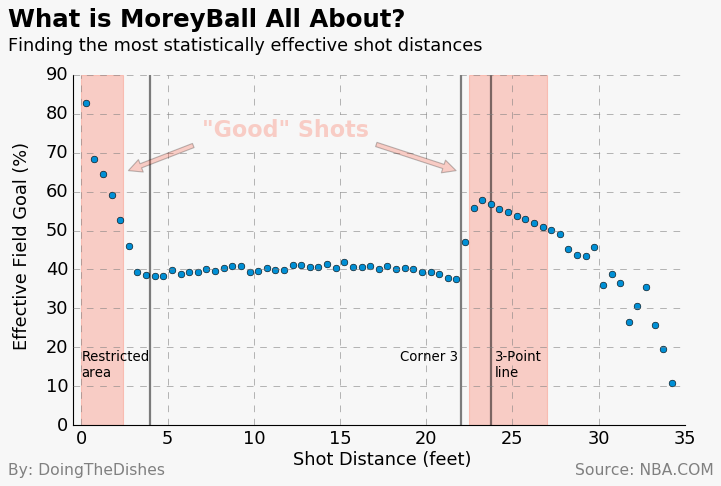

In [105]:
fig,ax = nice_plot(figsize=(9,6),xlabel='Shot Distance (feet)',ylabel='Effective Field Goal (%)',
                   title='What is MoreyBall All About?',subtitle='Finding the most statistically effective shot distances',
                  bg_color=(0.97,0.97,0.97))

x = 0.5*(bins[:-1]+bins[1:]) # get the average bin distance

ax.plot(x,100*y/2,'o',color=colors[0]) # convert po

ax.set_xlim([-0.5,35])

ax.fill_between([0,0,2.4,2.4],[10,90,90,10],color=colors[1],alpha=0.25)
ax.fill_between([22.5,22.5,27,27],[10,90,90,10],color=colors[1],alpha=0.25)

ax.vlines(22,ymin=0,ymax=90,color='k',alpha=0.5,linewidth=2)
ax.text(18.5,19.5,'Corner 3',verticalalignment='top')

ax.vlines(23.75,ymin=0,ymax=90,color='k',alpha=0.5,linewidth=2)
ax.text(24,19.5,'3-Point\nline',verticalalignment='top')

ax.annotate('"Good" Shots', xy=(2.5, 65), xytext=(7, 74),color=colors[1],
            alpha=0.25,fontsize=20,weight='bold',zorder=10,backgroundcolor=(0.97,0.97,0.97),
            arrowprops=dict(facecolor=colors[1], shrink=0.05,alpha=0.25),
            )

ax.annotate('"Good" Shots', xy=(22, 65), xytext=(7, 74),color=colors[1],
            alpha=0.0,fontsize=20,weight='bold',zorder=10,
            arrowprops=dict(facecolor=colors[1], shrink=0.05,alpha=0.25),
            )

fig.savefig('EFG_VS_SD.png',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')